# 1. Patch descriptors register in 3D for an rgb image - not what we want

## 1.1 load and pachify depth and rgb in 14*14 size patches

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
from torchvision.io import read_image
from PIL import Image

scene_id = 1
frame_id = 0
## 10* use :06d to turn to 6 digit - but also 10* to turn back just use int as str(int(scene_id)) 
scene_id = f"{scene_id:06d}"
frame_id = f"{frame_id:06d}"



rgb_img = np.array(Image.open(f"datasets/bop23_challenge/datasets/icbin/test/{scene_id}/rgb/{frame_id}.png"))
# depth image with pixel values as float (16 bit)
depth_img = np.array(Image.open(f"datasets/bop23_challenge/datasets/icbin/test/{scene_id}/depth/{frame_id}.png"), dtype="float32")

In [62]:
import torch.nn.functional as F
## To divide image into patches using patchify(image, patch_shape, step) - input as numpy image of (W,H,3)
## step in in pat defines the distance between one patch and the next one (vertically and horizontally). If step ≥ patch_height there is no overlap between patches in the same row. If step ≥ patch_width there is no overlap between patches in the same column.
## step=patch_size to make sure there is no overlap
# First, ensure the image dimensions are divisible by the patch size
# Ensure the image dimensions are divisible by the patch size
def pad_to_multiple(array, multiple):
    height, width, channels = array.shape
    pad_height = (multiple - height % multiple) % multiple
    pad_width = (multiple - width % multiple) % multiple
    padding = [(0, pad_height), (0, pad_width), (0, 0)]  # padd to the b
    return np.pad(array, padding, mode='constant')

#? Pad 0 to depth image might be wrong- should be infinite instead
patch_size = 14 
padded_rgb_img = pad_to_multiple(rgb_img, patch_size) #(490, 644, 3)
padded_depth_img = pad_to_multiple(np.expand_dims(depth_img, axis=-1), patch_size).squeeze() #(490, 644)

In [63]:
from patchify import patchify
rgb_patches = patchify(padded_rgb_img, (14,14,3), step=patch_size) # patch shape [14,14,3]
depth_patches = patchify(padded_depth_img, (14,14), step=patch_size) # patch shape [14,14]
# ## Merge the patches to 1 image again using unpatchify
# reconstructed_image = unpatchify(patches, image.shape)

In [64]:
rgb_patches.shape # (35, 46, 1, 14, 14, 3) ## means that we have create 35*46*1 = 1610 patches - 10* 1 is for the channel here only 1 patch for the channel
depth_patches.shape # (35, 46, 14, 14) ## means that we have create 35*46 = 1610 patches

(35, 46, 14, 14)

## 1.2 Filter invalid patches
Use the mask images to filter out these patches - if its center doesn't belong to the mask then is excluded
so we divide the rbg and masks in the same way then can just check the validity within the patches

In [70]:
# Load the masks - we have mutiple visible masks for the input iamge- sum it up (clip it in range of 0,1)- then u have the mask for the entire scene
# count the number of objects in the scene/frame via scene_gt_info.json

import json
scene_gt = json.load(open(f"datasets/bop23_challenge/datasets/icbin/test/{scene_id}/scene_gt_info.json", "r"))
num_objs = len(scene_gt[str(int(frame_id))])

masks = list()
for obj_id in range(num_objs):
    mask = np.array(Image.open(f"datasets/bop23_challenge/datasets/icbin/test/{scene_id}/mask_visib/{frame_id}_{obj_id:06d}.png"))
    masks.append(mask)

entire_mask = np.clip(np.sum(np.array(masks), axis=0), 0,1)

In [77]:
# Pad and patchify the mask
padded_mask = pad_to_multiple(np.expand_dims(entire_mask, axis=-1), patch_size).squeeze()
mask_patches = patchify(padded_mask, (14,14), step=patch_size) # patch shape [14,14]
mask_patches.shape

(35, 46, 14, 14)

In [89]:
# Fallen the patches for easier iteration
rgb_patches = rgb_patches.reshape(-1, patch_size, patch_size, 3)
mask_patches = mask_patches.reshape(-1, patch_size, patch_size)
depth_patches = depth_patches.reshape(-1, patch_size, patch_size)

valid_rgb_patches = []
valid_mask_patches = []
valid_depth_patches = []

## Center of an image is height/2, width/2 and here is (7,7)
for rgb_patch, mask_patch, depth_patch in zip(rgb_patches, mask_patches, depth_patches):
    center_y, center_x = patch_size // 2, patch_size // 2
    if mask_patch[center_y, center_x] == 1:  # Check if the center belongs to the foreground
        valid_rgb_patches.append(rgb_patch)
        valid_mask_patches.append(mask_patch)
        valid_depth_patches.append(depth_patch)

In [104]:
# Permute to tensor with shaape (num_patches, 3, 14, 14)
valid_rgb_patches = torch.tensor(valid_rgb_patches).permute(0,3,1,2)

/tmp/ipykernel_1307237/1390511641.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  valid_rgb_patches = torch.tensor(valid_rgb_patches).permute(0,3,1,2)


AttributeError: 'list' object has no attribute 'shape'

In [135]:
valid_depth_patches = torch.tensor(np.array(valid_depth_patches))
valid_mask_patches = torch.tensor(np.array(valid_mask_patches, dtype="uint8"))

## 1.3 Load features via Dinov2

In [91]:
# load config file
import hydra
from omegaconf import DictConfig, OmegaConf
from hydra import initialize, compose

# Initialize Hydra and compose the configuration
initialize(config_path="configs")
cfg = compose(config_name="run_inference")
OmegaConf.set_struct(cfg, False)

/tmp/ipykernel_1307237/531409554.py:7: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="configs")


In [92]:
from hydra.utils import instantiate
# define the cnos model
cfg_segmentor = cfg.model.segmentor_model
if "fast_sam" in cfg_segmentor._target_:
    logging.info("Using FastSAM, ignore stability_score_thresh!")
else:
    cfg.model.segmentor_model.stability_score_thresh = 0.97 # for sam
cfg.model.descriptor_model.model.num_block = 19

model = instantiate(cfg.model).to("cuda")

Using cache found in /home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main
/home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [93]:
model.descriptor_model.model.num_block

19

In [193]:
import torchvision.transforms as T
import torch.nn.functional as F

def patches_feature_extraction(valid_rgb_patches, cnos_model):
    # crop_rgb: numpy array
    temps = np.transpose(np.array(valid_rgb_patches), (0,2,3,1))
    rgb_normalize = T.Compose(
        [
            T.ToTensor(),
            T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ]
    )
    normalized_patches = torch.stack([rgb_normalize(patch) for patch in temps])
    with torch.no_grad(): 
        feature_patches= cnos_model.descriptor_model.model(normalized_patches.to("cuda"))
    return feature_patches

In [194]:
rgb_patch_features = patches_feature_extraction(valid_rgb_patches, model)

In [195]:
rgb_patch_features.shape

torch.Size([309, 1024])

# 2. Patch descriptors register in 3D for 642 templates

## 2.1 Load templates and divide into patches

In [203]:
import glob
import os
# Load templates
template_path = "datasets/bop23_challenge/datasets/templates_pyrender/icbin_642/obj_000001"
template_files = sorted(glob.glob(os.path.join(template_path, "*.png")), key=os.path.getmtime)

In [421]:
from PIL import Image
templates = [np.array(Image.open(template_file).convert("RGB").resize((420,420)))[:,:,:3] for template_file in template_files] # This image has 4 channels- the last one is not crucial - maybe about opacity

In [422]:
from patchify import patchify
# Divide each template into patches size 14*14*3
patch_size = 14
templates_patches = [patchify(template, (14,14,3), step=patch_size) for template in templates] 
# Shape(30, 30, 1, 14, 14, 3) for each patch - Flaten this array 
templates_patches = np.array([templates_patch.reshape(-1,14,14,3) for templates_patch in templates_patches])

In [423]:
templates_patches.shape

(642, 900, 14, 14, 3)

## 2.2 Filter out invalid patches
10* mask out the templates - clamp/clip at [0,1]

In [424]:
# Mask out the templates by clampping at 0,1 

masks_patches = np.clip(np.sum(templates_patches, axis=-1), 0, 1)

In [425]:
## Center of an image is height/2, width/2 and here is (7,7)
valid_templates_patches = list()
valid_masks_patches = list()
center_y, center_x = patch_size // 2, patch_size // 2

for template_patches, mask_patches in zip(templates_patches, masks_patches):
    valid_template_patches = list()
    valid_mask_patches = list()
    for template_patch, mask_patch in zip(template_patches, mask_patches):
        if mask_patch[center_y, center_x] == 1:  # Check if the center belongs to the foreground
            valid_template_patches.append(template_patch)
            valid_mask_patches.append(mask_patch)
    valid_templates_patches.append(np.array(valid_template_patches))
    valid_masks_patches.append(np.array(valid_mask_patches))


In [426]:
# Each template has different number of valid templates
print(valid_masks_patches[0].shape)
print(valid_templates_patches[0].shape)

(33, 14, 14)
(33, 14, 14, 3)


In [427]:
# Number of valid patches on each template
num_valid_patches = [valid_template_patches.shape[0] for valid_template_patches in valid_templates_patches] 
print(len(num_valid_patches), num_valid_patches)

642 [33, 35, 35, 36, 36, 34, 39, 41, 39, 37, 39, 41, 40, 41, 44, 41, 45, 44, 45, 45, 44, 43, 46, 45, 42, 42, 46, 47, 46, 46, 44, 50, 49, 46, 46, 48, 49, 50, 48, 50, 49, 47, 49, 49, 45, 45, 51, 49, 51, 53, 49, 53, 52, 51, 53, 50, 50, 53, 53, 50, 50, 52, 53, 53, 52, 54, 53, 54, 54, 50, 50, 55, 53, 55, 54, 51, 56, 55, 54, 52, 55, 55, 56, 56, 56, 54, 52, 55, 55, 54, 53, 54, 55, 56, 56, 56, 57, 56, 55, 54, 54, 55, 57, 58, 58, 55, 58, 57, 58, 57, 56, 56, 58, 58, 56, 56, 59, 58, 58, 59, 57, 56, 58, 59, 56, 56, 58, 59, 57, 58, 58, 59, 58, 59, 55, 56, 58, 59, 59, 59, 56, 60, 59, 57, 57, 59, 60, 58, 60, 60, 57, 57, 59, 59, 57, 57, 58, 60, 60, 60, 57, 57, 60, 60, 55, 57, 58, 59, 56, 58, 60, 60, 60, 60, 55, 56, 56, 59, 60, 59, 55, 60, 57, 60, 57, 56, 56, 57, 56, 59, 60, 59, 57, 60, 59, 57, 56, 59, 59, 56, 56, 57, 58, 57, 56, 60, 59, 59, 59, 56, 56, 58, 58, 57, 58, 59, 59, 60, 58, 56, 56, 60, 58, 57, 58, 59, 60, 58, 60, 58, 56, 57, 57, 58, 59, 59, 58, 59, 60, 58, 57, 58, 59, 60, 56, 57, 58, 58, 60,

## 2.3 Extract patch descriptors using Dinvo ViT L14 with DINOv2 with registers
Flatten the valid patches into shape (num_valid_patches, 14,14,3 )

In [428]:
# load config file
import hydra
from omegaconf import DictConfig, OmegaConf
from hydra import initialize, compose

# Initialize Hydra and compose the configuration
# initialize(config_path="configs")
cfg = compose(config_name="run_inference")
OmegaConf.set_struct(cfg, False)

In [429]:
from hydra.utils import instantiate
# choose only 18 first layers
cfg.model.descriptor_model.model.num_block = 18
model = instantiate(cfg.model).to("cuda")

Using cache found in /home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main


In [430]:
import torchvision.transforms as T
import torch.nn.functional as F

def patches_feature_extraction(valid_template_patches, cnos_model):
    # crop_rgb: numpy array
    # temps = np.transpose(np.array(valid_template_patches), (0,2,3,1))
    rgb_normalize = T.Compose(
        [
            T.ToTensor(),
            T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ]
    )
    normalized_patches = torch.stack([rgb_normalize(patch) for patch in valid_template_patches])
    with torch.no_grad(): 
        feature_patches= cnos_model.descriptor_model.model(normalized_patches.to("cuda"))
    return feature_patches

In [431]:
# Flatten the valid patches into shape (num_valid_patches, 14,14,3 )
valid_templates_patches = np.concatenate(valid_templates_patches, axis=0)
valid_masks_patches = np.concatenate(valid_masks_patches, axis=0) 

In [432]:
print(valid_masks_patches.shape)
print(valid_templates_patches.shape)

(35436, 14, 14)
(35436, 14, 14, 3)


In [433]:
templates_patches_features = patches_feature_extraction(valid_templates_patches, model)
templates_patches_features.shape

torch.Size([35436, 1024])

In [434]:
import numpy as np
from sklearn.decomposition import PCA

# Initialize PCA with the 256 components
pca = PCA(n_components=256)
pca_patches_descriptors = pca.fit_transform(np.array(templates_patches_features.cpu()))
pca_patches_descriptors.shape

(35436, 256)

## 2.4 Perform Kmean clustering for all patch descriptors from templates (2048 clusters)

In [435]:
# # Finding visual words as centroids of the descriptors
# import torch
# from torch_kmeans import KMeans

# model = KMeans(n_clusters=256)

# # Input size is (BS, N, D) 
# # only testing with the first 

# result = model(torch.tensor(pca_patches_descriptors).cuda().unsqueeze(0))
# print(result.labels)

In [436]:
from sklearn.cluster import MiniBatchKMeans
total_clusters = 2048
# Initialize the K-Means model
kmeans = MiniBatchKMeans(n_clusters = total_clusters)
# Fitting the model to training set
kmeans.fit(pca_patches_descriptors)

MiniBatchKMeans(n_clusters=2048)

In [437]:
kmeans.labels_

array([ 901,   28,   23, ..., 1828, 1463, 1177], dtype=int32)

In [438]:
templates_labels = list()
start_idx = 0
for num in num_valid_patches:
    end_idx = start_idx + num
    template_labels = kmeans.labels_[start_idx:end_idx]
    templates_labels.append(template_labels)
    start_idx = end_idx

In [439]:
np.max(kmeans.labels_)

2047

In [440]:
occurrences = np.bincount(templates_labels[0], minlength=2048)

In [441]:
len(templates_labels)

642

In [442]:
len(occurrences)

2048

In [443]:
import math

def calculate_templates_vector(templates_labels, num_clusters = 2048):
    # Calculate bag-of-words descriptors of the templates

    templates_vector = list()
    all_occurrences = [np.bincount(templates_label, minlength=2048) for templates_label in templates_labels]
    ni_array = np.sum(np.array(all_occurrences), axis = 0)
    N = len(templates_labels) # Number of templates
    for t in range(len(templates_labels)):
        template_vector = list()
        occurrences = np.bincount(templates_labels[t], minlength=2048)
        for i in range(num_clusters):
            n_it = occurrences[i] + 1
            nt = len(templates_labels[t]) + 1
            ni = ni_array[i]
            bi = n_it / nt * math.log(N / ni)
            template_vector.append(bi)
        templates_vector.append(np.array(template_vector))
    return templates_vector
templates_vector = calculate_templates_vector(templates_labels = templates_labels, num_clusters = 2048)

/tmp/ipykernel_1307237/601609967.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  bi = n_it / nt * math.log(N / ni)


In [444]:
templates_vector[0]

array([0.14936159, 0.1035338 , 0.10512402, ..., 0.14936159, 0.12241186,
       0.11960862])

# 3. Retrieving similar templates
Warp/crop object of image query

Resize crop to 420,420,3

Calculate bag_of_words descriptor of the crop

In [445]:
# Load image crop 
crop_rgb = np.array(Image.open("cnos_analysis/crop_proposals/crop1.png").convert("RGB")) # (124, 157, 3)

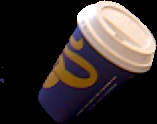